In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR']= '/content'

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

100% 1.98G/1.98G [01:02<00:00, 29.4MB/s]
100% 1.98G/1.98G [01:02<00:00, 34.1MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fruit-and-vegetable-image-recognition.zip', 'r')
zip_ref.extractall('/content/fruit-vegetables')
zip_ref.close()

In [5]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.1 MB/s eta 0:00:00


In [24]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

import numpy as np
from pathlib import Path
import tensorflow as tf
import pandas as pd

In [7]:
# Create a list with the filepaths for training and testing
train_dir = Path('/content/fruit-vegetables/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/content/fruit-vegetables/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('/content/fruit-vegetables/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [25]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [9]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['onion' 'pineapple' 'potato' 'grapes' 'banana' 'pear' 'cabbage'
 'bell pepper' 'eggplant' 'tomato' 'paprika' 'sweetpotato' 'lemon'
 'jalepeno' 'beetroot' 'pomegranate' 'spinach' 'soy beans' 'cucumber'
 'capsicum' 'orange' 'carrot' 'cauliflower' 'raddish' 'chilli pepper'
 'turnip' 'peas' 'sweetcorn' 'apple' 'garlic' 'watermelon' 'ginger'
 'lettuce' 'kiwi' 'corn' 'mango']


In [10]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)


,Filepath,Label
0,/content/fruit-vegetables/train/onion/Image_4.jpg,onion
1,/content/fruit-vegetables/train/pineapple/Imag...,pineapple
2,/content/fruit-vegetables/train/potato/Image_3...,potato
3,/content/fruit-vegetables/train/grapes/Image_2...,grapes
4,/content/fruit-vegetables/train/banana/Image_1...,banana


In [11]:
unique_labels = train_df.copy().drop_duplicates(subset=['Label']).reset_index()
train_df['Label'].nunique()

36

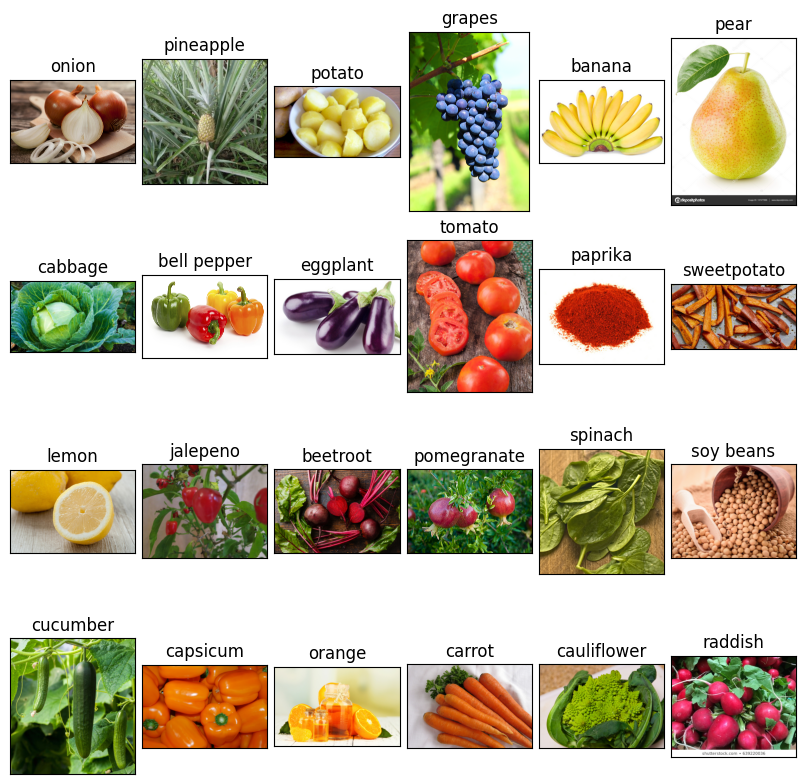

In [12]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(unique_labels.Filepath[i]))
    ax.set_title(unique_labels.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [13]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Common parameters for data generators
# common_params = dict(
#     target_size=(224, 224),
#     color_mode='rgb',
#     class_mode='categorical',
#     batch_size=32,
#     shuffle=True,
#     seed=0
# )

# # Data augmentation parameters
# augmentation_params = dict(
#     rotation_range=30,
#     zoom_range=0.15,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.15,
#     horizontal_flip=True,
#     fill_mode="nearest"
# )

# # Create a data generator with preprocessing function
# def create_data_generator(df, preprocessing_function, augmentation=False):
#     params = common_params.copy()
#     if augmentation:
#         params.update(augmentation_params)
#     generator = ImageDataGenerator(
#         preprocessing_function=preprocessing_function
#     ).flow_from_dataframe(
#         dataframe=df,
#         x_col='Filepath',
#         y_col='Label',
#         **params
#     )
#     return generator

# # Create data generators
# train_images = create_data_generator(train_df, tf.keras.applications.mobilenet_v2.preprocess_input, augmentation=True)
# val_images = create_data_generator(val_df, tf.keras.applications.mobilenet_v2.preprocess_input, augmentation=True)
# test_images = create_data_generator(test_df, tf.keras.applications.mobilenet_v2.preprocess_input, augmentation=False)

In [26]:
# Create image data generators with EfficientNetB7 pre-processing
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Specify the target image size and other parameters
image_size = (224, 224)
batch_size = 32

# Create data generators for training, validation, and testing
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=0
)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=0
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [27]:
# Load pre-trained MobileNetV2 model
base_model = EfficientNetB7(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

258076736/258076736 [==============================] - 8s 0us/step


In [28]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

In [29]:
# Add custom classification head on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Adjust the number of units if needed
x = Dense(len(train_images.class_indices), activation='softmax')(x)  # Output units match the number of classes

model = Model(inputs=base_model.input, outputs=x)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']    

In [20]:
# inputs = base_model.input

# x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)
# x = tf.keras.layers.Dense(128, activation='relu')(x)

# outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [31]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])



In [32]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)


In [33]:
# Define the number of epochs, steps, and early stopping

early_stopping = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
num_epochs = 5
steps_per_epoch = len(train_images)
validation_steps = len(val_images)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_images,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_images,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/5
87/87 [==============================] - 161s 1s/step - loss: 1.4069 - accuracy: 0.6248 - val_loss: 0.4074 - val_accuracy: 0.8743
Epoch 2/5
87/87 [==============================] - 84s 968ms/step - loss: 0.5574 - accuracy: 0.8219 - val_loss: 0.2940 - val_accuracy: 0.8982
Epoch 3/5
87/87 [==============================] - 92s 1s/step - loss: 0.3988 - accuracy: 0.8655 - val_loss: 0.2450 - val_accuracy: 0.9222
Epoch 4/5
87/87 [==============================] - 81s 933ms/step - loss: 0.3203 - accuracy: 0.8899 - val_loss: 0.2073 - val_accuracy: 0.9281
Epoch 5/5
87/87 [==============================] - 96s 1s/step - loss: 0.2469 - accuracy: 0.9155 - val_loss: 0.2158 - val_accuracy: 0.9222


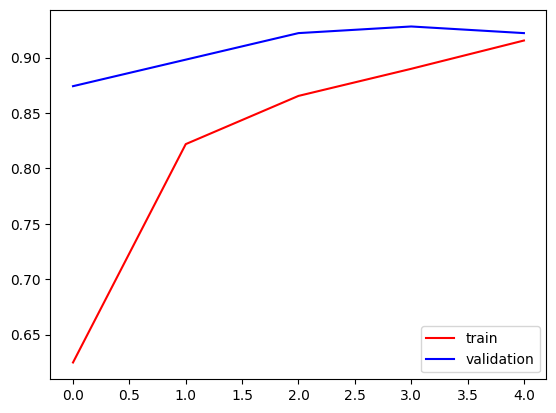

In [34]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

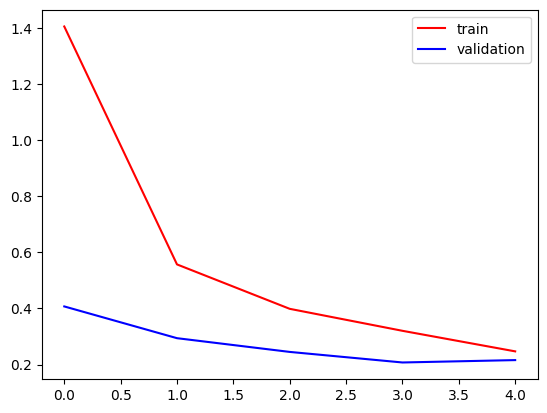

In [35]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [41]:
# Make predictions on the test set
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Map numeric labels to class names
label_mapping = {v: k for k, v in train_images.class_indices.items()}
predicted_classes = [label_mapping[label] for label in predicted_labels]
true_labels = [label_mapping[label] for label in test_images.classes]


11/11 [==============================] - 11s 881ms/step


In [42]:
# Calculate accuracy
acc = accuracy_score(true_labels, predicted_classes)
print(f'Accuracy on the test set: {100 * acc:.2f}%')


Accuracy on the test set: 92.22%


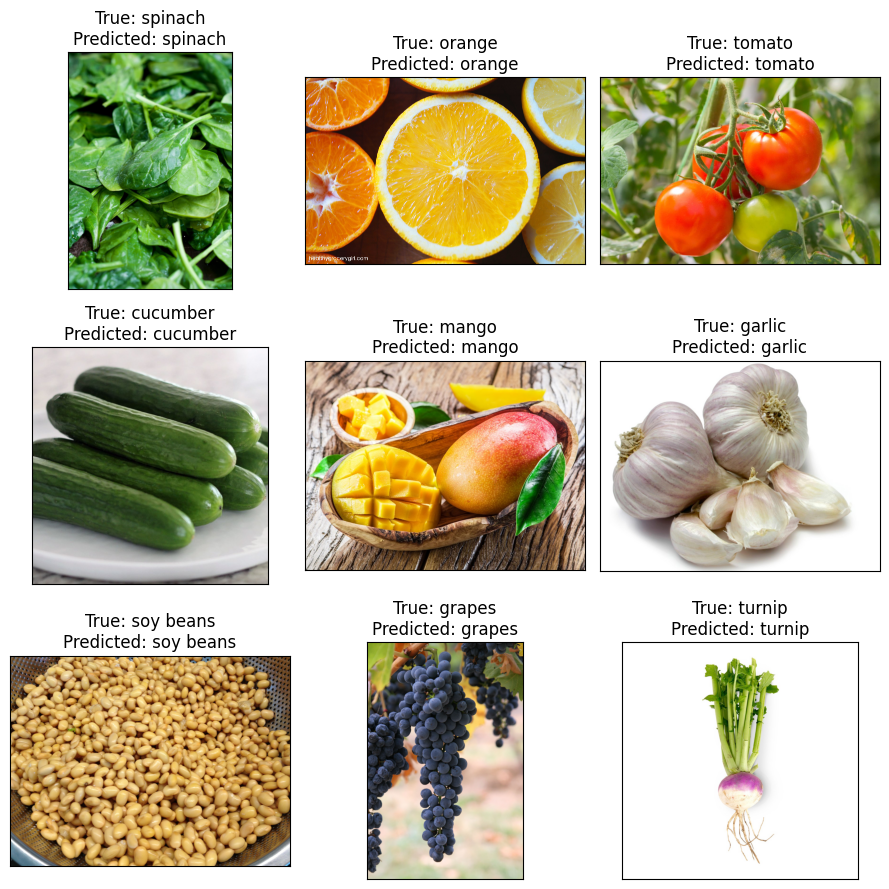

In [43]:
# Display a few sample predictions
sample_indices = np.random.choice(len(test_df), size=9, replace=False)
sample_images = [plt.imread(test_df.Filepath.iloc[i]) for i in sample_indices]
sample_labels = [f"True: {true_labels[i]}\nPredicted: {predicted_classes[i]}" for i in sample_indices]

# Display the sample images with predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9),
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, img, label in zip(axes.flat, sample_images, sample_labels):
    ax.imshow(img)
    ax.set_title(label)

plt.tight_layout()
plt.show()